In [ ]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/images_detection -r /content

In [ ]:
file_path = '/content/images_detection'

In [ ]:
name_class = os.listdir(file_path)
name_class

['glass', 'plastic', 'paper', 'cardboard', 'metal']

In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))
filepaths

['/content/images_detection/glass/1ZFINTFFA6AE_jpg.rf.ae7f585b6f534fe101e1302b79f3c2ba.jpg',
 '/content/images_detection/glass/GNSXEE5S6RJ4_jpg.rf.30590e29ebb1c1fa39d366bcaf523d52.jpg',
 '/content/images_detection/glass/glass245_jpg.rf.8ce679f00951b23eeba1c5452c9fbba8.jpg',
 '/content/images_detection/glass/glass50_jpg.rf.7a56cdc2ab0753a7223759ed2cfc88d7.jpg',
 '/content/images_detection/glass/glass427_jpg.rf.e4fc11c2585445364ed3cda5128b9a72.jpg',
 '/content/images_detection/glass/glass381_jpg.rf.f4193502c82d23b6b1cf21a05851ade4.jpg',
 '/content/images_detection/glass/glass45_jpg.rf.d17b06e8e2fb8c5f87d556292647b43c.jpg',
 '/content/images_detection/glass/glass488_jpg.rf.e9edb9bf3cdd1dd3c5714abebecc8426.jpg',
 '/content/images_detection/glass/glass132_jpg.rf.681d58da39f7436a42a139065c510a6f.jpg',
 '/content/images_detection/glass/glass232_jpg.rf.a5f8c009bccc2e8649b22462b91e62d7.jpg',
 '/content/images_detection/glass/glass477_jpg.rf.2b72371ce411062411f6b6d17deda81e.jpg',
 '/content/imag

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

['glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',
 'glass',


In [ ]:

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,/content/images_detection/paper/paper129_jpg.r...,paper
1,/content/images_detection/cardboard/cardboard-...,cardboard
2,/content/images_detection/metal/metal1091_jpg....,metal
3,/content/images_detection/paper/paper2059_jpg....,paper
4,/content/images_detection/paper/paper634_jpg.r...,paper


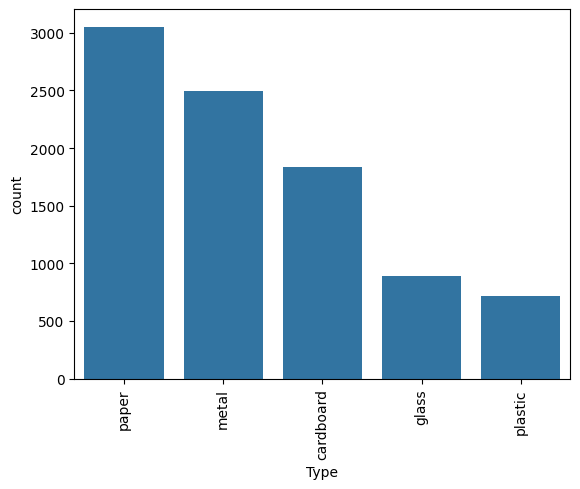

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6739 validated image filenames belonging to 5 classes.
Found 2247 validated image filenames belonging to 5 classes.
Found 2247 validated image filenames belonging to 5 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30
)

Epoch 1/30
211/211 [==============================] - 426s 2s/step - loss: 0.4916 - accuracy: 0.8273 - val_loss: 0.3396 - val_accuracy: 0.8816
Epoch 2/30
211/211 [==============================] - 420s 2s/step - loss: 0.2194 - accuracy: 0.9224 - val_loss: 0.2907 - val_accuracy: 0.8932
Epoch 3/30
211/211 [==============================] - 454s 2s/step - loss: 0.1215 - accuracy: 0.9605 - val_loss: 0.2508 - val_accuracy: 0.9203
Epoch 4/30
211/211 [==============================] - 454s 2s/step - loss: 0.0709 - accuracy: 0.9794 - val_loss: 0.2795 - val_accuracy: 0.9132
Epoch 5/30
211/211 [==============================] - 455s 2s/step - loss: 0.0577 - accuracy: 0.9834 - val_loss: 0.2738 - val_accuracy: 0.9248
Epoch 6/30
211/211 [==============================] - 453s 2s/step - loss: 0.0565 - accuracy: 0.9820 - val_loss: 0.2503 - val_accuracy: 0.9332
Epoch 7/30
211/211 [==============================] - 457s 2s/step - loss: 0.0336 - accuracy: 0.9912 - val_loss: 0.2080 - val_accuracy: 0.9488

In [ ]:
model.save("model_resnet50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


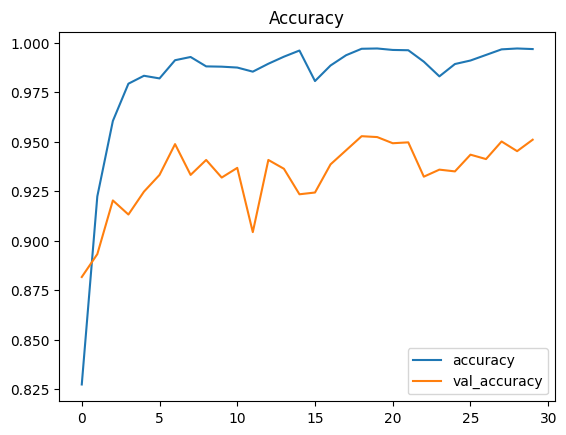

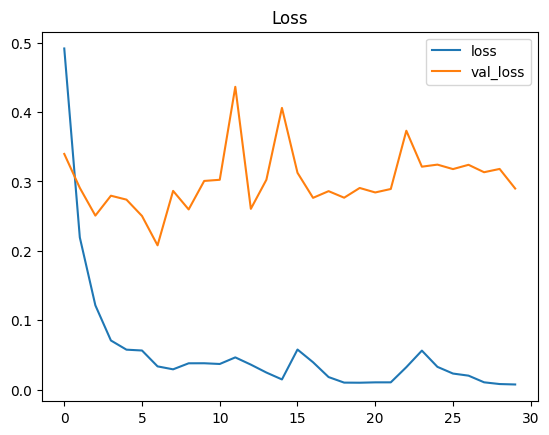

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.28981
Test Accuracy: 95.10%


In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

71/71 [==============================] - 106s 1s/step


In [ ]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   cardboard       0.98      0.97      0.97       501
       glass       0.91      0.90      0.91       207
       metal       0.95      0.97      0.96       623
       paper       0.96      0.96      0.96       740
     plastic       0.92      0.84      0.88       176

    accuracy                           0.95      2247
   macro avg       0.94      0.93      0.93      2247
weighted avg       0.95      0.95      0.95      2247

